In [33]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

##### Load Data

In [34]:
# Define date range
start_date = '2010-01-01'
end_date = '2023-10-04'

# Retrieve data
data = yf.download('AAPL', start=start_date, end=end_date)

# Save data to a .pkl file
data.to_pickle('aapl.pkl')

[*********************100%***********************]  1 of 1 completed


In [35]:
# Read dataset
df = pd.read_pickle('aapl.pkl')
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487533,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498750,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383556,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800


In [36]:
# Reset indexes
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487533,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498750,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395380,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383556,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800


In [37]:
# Keep required columns
df = df.drop(['Date', 'Adj Close'], axis=1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


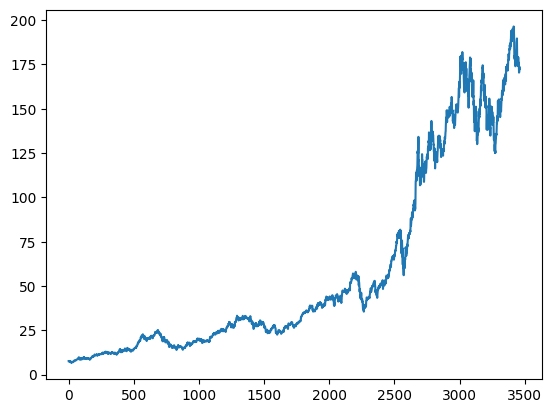

In [38]:
# Our subject of interest is going to be at what price the stock closes
plt.plot(df.Close)

In [39]:
# 100 days Moving Average
MA100 = df.Close.rolling(window=100).mean()
MA100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3456    182.075901
3457    182.047101
3458    182.024201
3459    182.044001
3460    182.032401
Name: Close, Length: 3461, dtype: float64

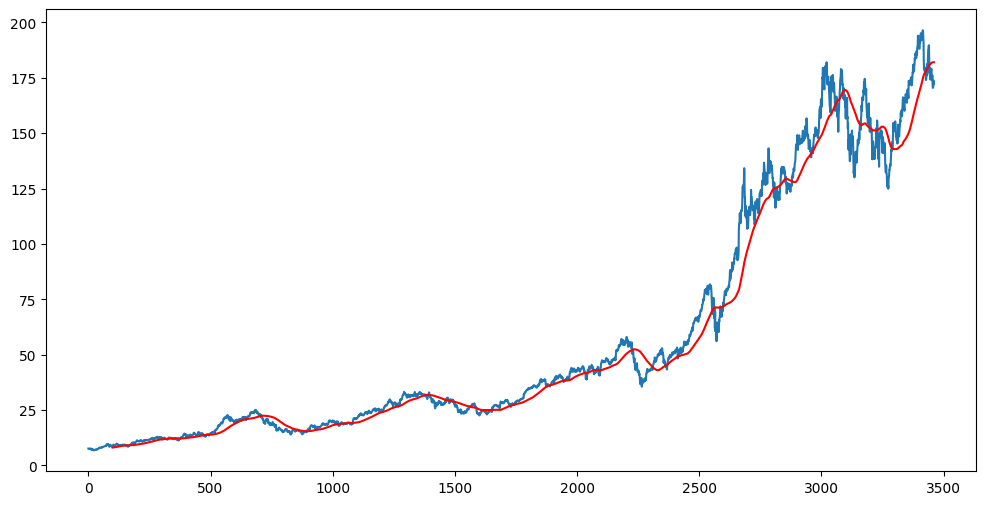

In [40]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(MA100, 'r')

In [41]:
# 200 days Moving Average
MA200 = df.Close.rolling(window=200).mean()
MA200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3456    165.94580
3457    166.08845
3458    166.22205
3459    166.36345
3460    166.50940
Name: Close, Length: 3461, dtype: float64

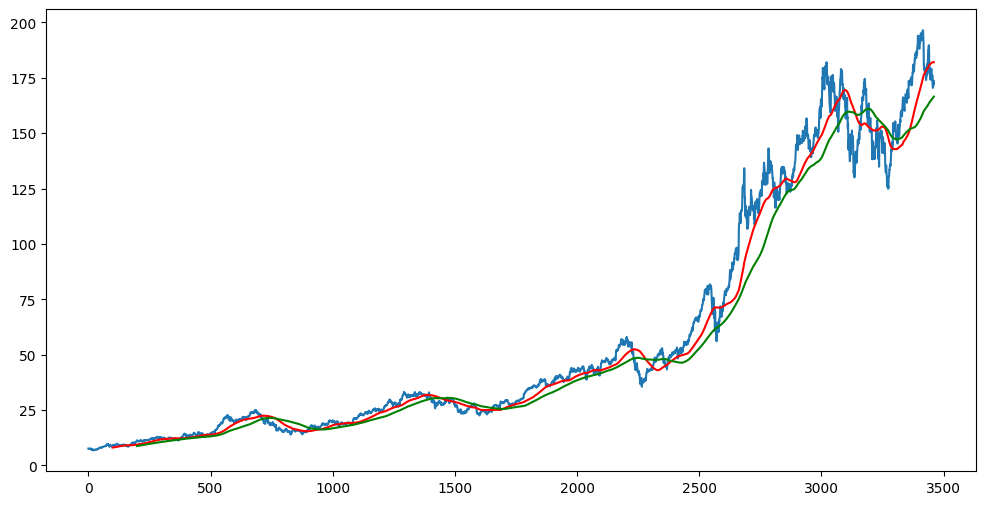

In [42]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(MA100, 'r')
plt.plot(MA200, 'g')

###### The price of stock increases when 100MA is greater than 200MA

In [43]:
df.shape

(3461, 5)

#### Splitting data into training and testing set

In [44]:
# Splitting into training and testing data into 70:30 ratio

data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(2422, 1)
(1039, 1)


#### Scale Data

In [45]:
# Scale down dataset i.e, normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.01533047],
       [0.01558878],
       [0.01320823],
       ...,
       [0.85671997],
       [0.85178436],
       [0.87504534]])

In [46]:
X_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    X_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

#### Build LSTM Model

In [47]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [48]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True,
        input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

#### Train Data

In [50]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
73/73 [==============================] - 19s 185ms/step - loss: 0.0378
Epoch 2/50
73/73 [==============================] - 14s 187ms/step - loss: 0.0082
Epoch 3/50
73/73 [==============================] - 14s 196ms/step - loss: 0.0070
Epoch 4/50
73/73 [==============================] - 14s 195ms/step - loss: 0.0058
Epoch 5/50
73/73 [==============================] - 15s 204ms/step - loss: 0.0067
Epoch 6/50
73/73 [==============================] - 14s 195ms/step - loss: 0.0055
Epoch 7/50
73/73 [==============================] - 25s 346ms/step - loss: 0.0048
Epoch 8/50
73/73 [==============================] - 21s 280ms/step - loss: 0.0051
Epoch 9/50
73/73 [==============================] - 14s 186ms/step - loss: 0.0050
Epoch 10/50
73/73 [==============================] - 13s 183ms/step - loss: 0.0048
Epoch 11/50
73/73 [==============================] - 19s 259ms/step - loss: 0.0042
Epoch 12/50
73/73 [==============================] - 13s 182ms/step - loss: 0.0041
Epoch 13/50
7

#### Save the Model

In [51]:
model.save('stock_predictor.h5')

#### Test

In [52]:
data_testing.head()

,Close
2422,52.587502
2423,52.590000
2424,53.160000
2425,53.115002
2426,50.660000


In [53]:
past_100_days = pd.DataFrame(data_training.tail(100))

In [54]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
final_df.head()

,Close
0,47.117500
1,47.180000
2,47.487499
3,47.810001
4,48.505001


In [55]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.02476734],
       [0.02517551],
       [0.02718366],
       ...,
       [0.83516741],
       [0.85175512],
       [0.84293875]])

In [56]:
X_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    X_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

In [57]:
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(1039, 100, 1)
(1039,)


In [58]:
# Making predictions
y_predicted = model.predict(X_test)

33/33 [==============================] - 2s 51ms/step


In [59]:
y_predicted.shape

(1039, 1)

In [60]:
y_test

array([0.0604898 , 0.06050612, 0.06422857, ..., 0.83516741, 0.85175512,
       0.84293875])

In [61]:
y_predicted

array([[0.11767866],
       [0.11765857],
       [0.1176846 ],
       ...,
       [0.7901232 ],
       [0.7880653 ],
       [0.785954  ]], dtype=float32)

In [62]:
scaler.scale_

array([0.00653061])

In [63]:
scale_factor = 1/0.02123255
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

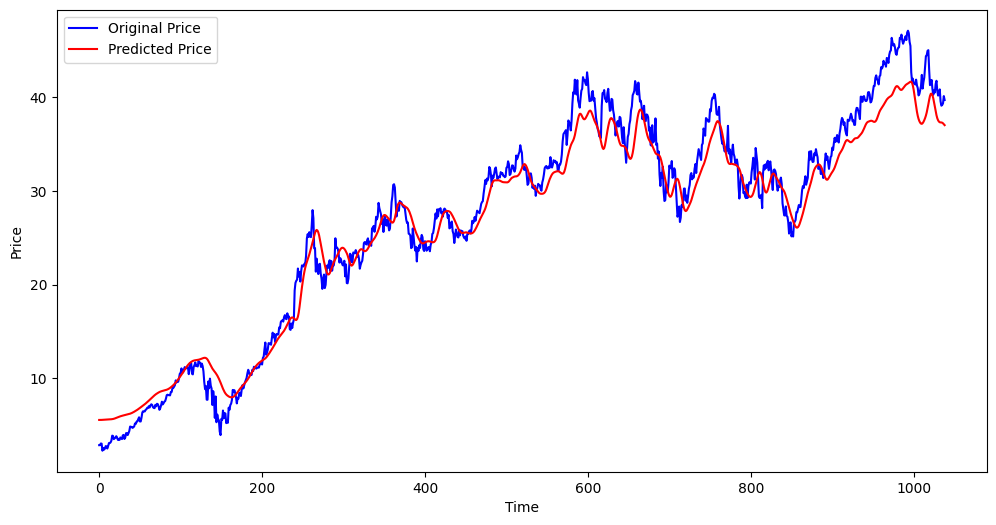

In [64]:
# Plot Original Price and Predicted Price
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()